In [1]:
import pandas as pd
import re
import nltk
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/pranav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
train_csv_file = 'train.csv'
test_csv_file = 'test.csv'

train_data = pd.read_csv(train_csv_file)
test_data = pd.read_csv(test_csv_file)

dev_set_size = 7600
train_set = train_data.iloc[dev_set_size:]
dev_set = train_data.iloc[:dev_set_size]

train_sentences = train_set['Description'].tolist()
train_labels = train_set['Class Index'].tolist()
dev_sentences = dev_set['Description'].tolist()
dev_labels = dev_set['Class Index'].tolist()
test_sentences = test_data['Description'].tolist()
test_labels = test_data['Class Index'].tolist()

def clean_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
    tokens = sentence.split()
    return ' '.join(tokens)

train_sentences_cleaned = [clean_sentence(sentence) for sentence in train_sentences]
dev_sentences_cleaned = [clean_sentence(sentence) for sentence in dev_sentences]
test_sentences_cleaned = [clean_sentence(sentence) for sentence in test_sentences]

train_sentences_tokenized = [word_tokenize(sentence) for sentence in train_sentences_cleaned]
dev_sentences_tokenized = [word_tokenize(sentence) for sentence in dev_sentences_cleaned]
test_sentences_tokenized = [word_tokenize(sentence) for sentence in test_sentences_cleaned]

train_data = pd.read_csv('train.csv')
length = []
for i in range(len(train_data['Description'])):
    sentence = re.findall(r"[\w']+|[.,!?;'-]", train_data['Description'][i])
    length.append(len(sentence))
length.sort()
max_seq_length = length[int(0.95*len(length))]+1


def pad_sequences(sentences, max_length):
    padded_sentences = []
    for sentence in sentences:
        if len(sentence) >= max_length:
            padded_sentences.append(sentence[:max_length])
        else:
            padded_sentences.append(sentence + ['<PAD>'] * (max_length - len(sentence)))
    return padded_sentences

train_sentences_padded = pad_sequences(train_sentences_tokenized, max_seq_length)
dev_sentences_padded = pad_sequences(dev_sentences_tokenized, max_seq_length)
test_sentences_padded = pad_sequences(test_sentences_tokenized, max_seq_length)

In [4]:
print("Train Set Sentences (Padded):")
print(train_sentences_padded[:2])
print("Train Set Labels:")
print(train_labels[:2])

Train Set Sentences (Padded):
[['such', 'an', 'embarrassment', 'of', 'riches', 'apple', 'macintosh', 'users', 'have', 'two', 'new', 'web', 'browsers', 'to', 'choose', 'from', 'it', 's', 'a', 'curious', 'market', 'all', 'macs', 'come', 'with', 'two', 'free', 'browsers', 'microsoft', 's', 'internet', 'explorer', 'and', 'apple', 's', 'own', 'slick', 'and', 'elegant', 'safari', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'], ['the', 'women', 's', 'gold', 'medallist', 'in', 'shot', 'put', 'irina', 'korzhanenko', 'has', 'been', 'disqualified', 'from', 'the', 'olympics', 'and', 'stripped', 'of', 'her', 'medal', 'after', 'testing', 'positive', 'for', 'doping', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>',

In [5]:
all_words = [word for sentence in train_sentences_tokenized for word in sentence]
word_counts = Counter(all_words)

vocab = ['<UNK>', '<PAD>'] + [word for word, count in word_counts.items()]
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for idx, word in enumerate(vocab)}

def sentence_to_indices(sentence, word2idx):
    return [word2idx.get(word, word2idx['<UNK>']) for word in sentence]

train_indices_elmo = [sentence_to_indices(sentence, word2idx) for sentence in train_sentences_padded]
dev_indices_elmo = [sentence_to_indices(sentence, word2idx) for sentence in dev_sentences_padded]
test_indices_elmo = [sentence_to_indices(sentence, word2idx) for sentence in test_sentences_padded]

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
class ELMo(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, embedding_matrix):
        super(ELMo, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # Embedding Layer, Default- freeze = True
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)

        # Forward Language Model
        self.lstm_forward1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.lstm_forward2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear_mode1 = nn.Linear(2*hidden_dim, vocab_size)

        # Backward Language Model
        self.lstm_backward1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.lstm_backward2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear_mode2 = nn.Linear(2*hidden_dim, vocab_size)

    def forward(self, input_data):
        forward_embed = self.embedding(input_data)
        forward_lstm1, _ = self.lstm_forward1(forward_embed)
        forward_lstm2, _ = self.lstm_forward2(forward_lstm1)

        input_data = torch.flip(input_data, dims=[1])
        backward_embed = self.embedding(input_data)
        backward_lstm1, _ = self.lstm_backward1(backward_embed)
        backward_lstm2, _ = self.lstm_backward2(backward_lstm1)
        
        # Flip bacward_lstm words, Concatenate forward1 and backward1 outputs
        backward_lstm1 = torch.flip(backward_lstm1, dims=[1])
        lstm_concat1 = torch.cat((forward_lstm1, backward_lstm1), dim=-1)
        
        # Concatenate forward2 and backward2 outputs
        backward_lstm2 = torch.flip(backward_lstm2, dims=[1])
        lstm_concat2 = torch.cat((forward_lstm2, backward_lstm2), dim=-1)

        # Concatenate forward and backward embeddings word by word
        embedding_concat = torch.cat((forward_embed, forward_embed), dim=-1)
        
        return embedding_concat, lstm_concat1, lstm_concat2

In [8]:
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 100

elmo = ELMo(vocab_size, embedding_dim, hidden_dim, torch.rand(vocab_size, embedding_dim)).to(device)

In [10]:
elmo.load_state_dict(torch.load('pretrained_elmo.zip', map_location=device))
elmo.to(device)

ELMo(
  (embedding): Embedding(81098, 100)
  (lstm_forward1): LSTM(100, 100, batch_first=True)
  (lstm_forward2): LSTM(100, 100, batch_first=True)
  (linear_mode1): Linear(in_features=200, out_features=81098, bias=True)
  (lstm_backward1): LSTM(100, 100, batch_first=True)
  (lstm_backward2): LSTM(100, 100, batch_first=True)
  (linear_mode2): Linear(in_features=200, out_features=81098, bias=True)
)

In [11]:
train_data_elmo = torch.tensor(train_indices_elmo, dtype=torch.long)
dev_data_elmo = torch.tensor(dev_indices_elmo, dtype=torch.long)
test_data_elmo = torch.tensor(test_indices_elmo, dtype=torch.long)

train_data_with_labels = TensorDataset(train_data_elmo[:100000], torch.tensor(train_labels[:100000], dtype=torch.long))
dev_data_with_labels = TensorDataset(dev_data_elmo[:5000], torch.tensor(dev_labels[:5000], dtype=torch.long))
test_data_with_labels = TensorDataset(test_data_elmo[:5000], torch.tensor(test_labels[:5000], dtype=torch.long))

batch_size = 32

train_loader = DataLoader(train_data_with_labels, batch_size=batch_size, shuffle=False)
dev_loader = DataLoader(dev_data_with_labels, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data_with_labels, batch_size=batch_size, shuffle=False)

In [12]:
print(train_data_with_labels[:1])

(tensor([[ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         20, 21, 22, 23, 24, 25, 26, 11, 27, 14, 28, 19, 29, 30, 31,  7, 19, 32,
         33, 31, 34, 35,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1]]), tensor([4]))


## Downstream Task and Hyperparameter Tuning

In [52]:
class LSTM(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, num_layers = 1):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional=False, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.weights = nn.Parameter(torch.tensor([0.33, 0.33, 0.33], dtype=torch.float32))
        self.gamma = nn.Parameter(torch.tensor(1, dtype=torch.float32))


    def forward(self, embedding1, embedding2, embedding3):
        weights = nn.functional.softmax(self.weights, dim = 0)
        x = (embedding3*weights[0] + embedding1*weights[1] + embedding2*weights[2])*self.gamma
        batch_size = x.size(0)

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        
        output, (hn, cn) = self.lstm(x, (h0, c0))                            # Initialize hidden state
        output_last = output[:, -1]                                          # Take the output from the last time step
        output_fc = self.fc(output_last)                                     # Pass it through the fully connected layer
        return output_fc

In [53]:
output_dim = train_data['Class Index'].unique().shape[0]
embedding_dim = 200
hidden_dim = 200

lstm = LSTM(output_dim, embedding_dim, hidden_dim).to(device)

In [25]:
def train_lstm(model,elmo_model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    elmo_model.eval()

    for input_seq, target_seq in tqdm(train_loader):
        input_seq = input_seq.to(device)
        target_seq = target_seq - 1
        target_seq = target_seq.to(device)
        optimizer.zero_grad()

        embedding1, embedding2, embedding3 = elmo_model(input_seq)

        outputs = model(embedding1, embedding2, embedding3)
        loss = criterion(outputs, target_seq) 
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        predicted = torch.argmax(outputs, dim = 1)
        correct += torch.sum(target_seq == predicted).item()
        total += target_seq.shape[0]
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss, correct / total

In [43]:
def evaluate_lstm(model, elmo_model, dev_loader):
    model.eval()

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for input_seq, target_seq in tqdm(dev_loader):
            input_seq = input_seq.to(device)
            target_seq = target_seq - 1
            target_seq = target_seq.to(device)

            embedding1, embedding2, embedding3 = elmo_model(input_seq)

            outputs = model(embedding1, embedding2, embedding3)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(target_seq.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    return true_labels, predicted_labels

#### Trainable Lambdas

In [64]:
def evaluation_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)*100
    precision = precision_score(predicted_labels, true_labels, average='weighted')*100
    recall = recall_score(predicted_labels, true_labels, average='weighted')*100
    f1 = f1_score(predicted_labels, true_labels, average='weighted')*100
    confusion = confusion_matrix(predicted_labels, true_labels)
    print(f"Accuracy = {accuracy}")
    print(f"Recall = {recall}")
    print(f"F1-Score = {f1}")
    print(f"Precision = {precision}")
    print(f"Confusion Matrix: \n{confusion}\n")
    return

In [39]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr = 1e-3)

for epoch in range(num_epochs):
    train_loss, accuracy = train_lstm(lstm, elmo, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}/{num_epochs} (Train) - Loss: {train_loss:.4f} Training Set Accuracy {accuracy*100}")

100%|██████████| 3125/3125 [02:52<00:00, 18.12it/s]


Epoch 1/10 (Train) - Loss: 0.6956 Training Set Accuracy 69.708


100%|██████████| 3125/3125 [02:43<00:00, 19.15it/s]


Epoch 2/10 (Train) - Loss: 0.3190 Training Set Accuracy 88.78


100%|██████████| 3125/3125 [02:59<00:00, 17.36it/s]


Epoch 3/10 (Train) - Loss: 0.2702 Training Set Accuracy 90.593


100%|██████████| 3125/3125 [02:51<00:00, 18.21it/s]


Epoch 4/10 (Train) - Loss: 0.2339 Training Set Accuracy 91.955


100%|██████████| 3125/3125 [02:54<00:00, 17.91it/s]


Epoch 5/10 (Train) - Loss: 0.1995 Training Set Accuracy 93.189


100%|██████████| 3125/3125 [02:58<00:00, 17.55it/s]


Epoch 6/10 (Train) - Loss: 0.1681 Training Set Accuracy 94.316


100%|██████████| 3125/3125 [02:48<00:00, 18.50it/s]


Epoch 7/10 (Train) - Loss: 0.1420 Training Set Accuracy 95.185


100%|██████████| 3125/3125 [02:50<00:00, 18.35it/s]


Epoch 8/10 (Train) - Loss: 0.1188 Training Set Accuracy 96.054


100%|██████████| 3125/3125 [02:52<00:00, 18.09it/s]


Epoch 9/10 (Train) - Loss: 0.1024 Training Set Accuracy 96.599


100%|██████████| 3125/3125 [02:23<00:00, 21.80it/s]

Epoch 10/10 (Train) - Loss: 0.0891 Training Set Accuracy 97.024


In [58]:
nn.functional.softmax(lstm.weights, dim = 0), lstm.gamma

(tensor([0.2493, 0.3161, 0.4346], grad_fn=<SoftmaxBackward0>),
 Parameter containing:
 tensor(1.6485, requires_grad=True))

In [41]:
torch.save(lstm.state_dict(), 'classifier.pt')

In [78]:
true_labels, predicted_labels = evaluate_lstm(lstm, elmo, test_loader)
evaluation_metrics(true_labels=true_labels, predicted_labels=predicted_labels)

100%|██████████| 157/157 [00:02<00:00, 68.60it/s]

Accuracy = 89.78
Recall = 89.78
F1-Score = 89.79872608594803
Precision = 89.94152474201607
Confusion Matrix: 
[[1124   10   30   35]
 [  50 1243   12   13]
 [  64    9 1011   81]
 [  48    8  151 1111]]



#### Frozen Lambdas

In [75]:
output_dim = train_data['Class Index'].unique().shape[0]
embedding_dim = 200
hidden_dim = 200
num_epochs = 10

lstm1 = LSTM(output_dim, embedding_dim, hidden_dim).to(device)
initial_weights = torch.randn(3, dtype = torch.float32, device = device)
initial_weights = nn.functional.softmax(initial_weights, dim = 0)
lstm1.weights = torch.nn.Parameter(initial_weights)
print(lstm1.weights, lstm1.gamma)

# Freeze the weights
lstm1.weights.requires_grad = False
lstm1.gamma.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm1.parameters(), lr = 1e-3)


print(f"For Initial Weights = {initial_weights}\n\n")

print("Training the Model\n")
for epoch in range(num_epochs):
    train_loss, accuracy = train_lstm(lstm1, elmo, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}/{num_epochs} (Train) - Loss: {train_loss:.4f} Training Set Accuracy {accuracy*100}")

print(lstm1.weights, lstm1.gamma)

print("Testing the Model on Test Set")
true_labels, predicted_labels = evaluate_lstm(lstm1, elmo, test_loader)
evaluation_metrics(true_labels=true_labels, predicted_labels=predicted_labels)

Parameter containing:
tensor([0.7442, 0.1868, 0.0690], requires_grad=True) Parameter containing:
tensor(1., requires_grad=True)
For Initial Weights = tensor([0.7442, 0.1868, 0.0690])


Training the Model



100%|██████████| 3125/3125 [02:23<00:00, 21.83it/s]


Epoch 1/10 (Train) - Loss: 0.7529 Training Set Accuracy 67.105


100%|██████████| 3125/3125 [02:22<00:00, 21.90it/s]


Epoch 2/10 (Train) - Loss: 0.3443 Training Set Accuracy 87.864


100%|██████████| 3125/3125 [02:19<00:00, 22.43it/s]


Epoch 3/10 (Train) - Loss: 0.2972 Training Set Accuracy 89.483


100%|██████████| 3125/3125 [02:20<00:00, 22.27it/s]


Epoch 4/10 (Train) - Loss: 0.2659 Training Set Accuracy 90.59700000000001


100%|██████████| 3125/3125 [02:22<00:00, 21.91it/s]


Epoch 5/10 (Train) - Loss: 0.2381 Training Set Accuracy 91.582


100%|██████████| 3125/3125 [02:23<00:00, 21.77it/s]


Epoch 6/10 (Train) - Loss: 0.2110 Training Set Accuracy 92.54599999999999


100%|██████████| 3125/3125 [02:24<00:00, 21.64it/s]


Epoch 7/10 (Train) - Loss: 0.1860 Training Set Accuracy 93.506


100%|██████████| 3125/3125 [02:22<00:00, 21.87it/s]


Epoch 8/10 (Train) - Loss: 0.1637 Training Set Accuracy 94.337


100%|██████████| 3125/3125 [02:21<00:00, 22.15it/s]


Epoch 9/10 (Train) - Loss: 0.1455 Training Set Accuracy 94.931


100%|██████████| 3125/3125 [02:21<00:00, 22.08it/s]


Epoch 10/10 (Train) - Loss: 0.1298 Training Set Accuracy 95.50699999999999
Parameter containing:
tensor([0.7442, 0.1868, 0.0690]) Parameter containing:
tensor(1.)
Testing the Model on Test Set


100%|██████████| 157/157 [00:02<00:00, 60.46it/s]

Accuracy = 88.78
Recall = 88.78
F1-Score = 88.80254126888259
Precision = 88.9050533896645
Confusion Matrix: 
[[1131   18   43   43]
 [  47 1229   15   18]
 [  57    9  992   92]
 [  51   14  154 1087]]



In [79]:
true_labels, predicted_labels = evaluate_lstm(lstm, elmo, train_loader)
evaluation_metrics(true_labels=true_labels, predicted_labels=predicted_labels)

100%|██████████| 3125/3125 [00:49<00:00, 62.54it/s]


Accuracy = 94.829
Recall = 94.829
F1-Score = 94.83753983076268
Precision = 94.93347362900482
Confusion Matrix: 
[[23281    50   284   272]
 [  481 24875   152   131]
 [  743    42 22599   582]
 [  527    53  1854 24074]]



In [80]:
true_labels, predicted_labels = evaluate_lstm(lstm1, elmo, train_loader)
evaluation_metrics(true_labels=true_labels, predicted_labels=predicted_labels)

100%|██████████| 3125/3125 [00:52<00:00, 59.38it/s]


Accuracy = 93.42
Recall = 93.42
F1-Score = 93.42824243025008
Precision = 93.54659342881327
Confusion Matrix: 
[[23447   177   506   488]
 [  352 24630   162   146]
 [  625    91 21730   812]
 [  608   122  2491 23613]]



**Learnable Function** - The Input Sequence is passed to the ELMO model for the generation of the 3 embeddings (Forward, Backward and Glove Embeddings). Then, simply a Linear Combination of Vectors obtained is done with the appropriate Trained scaling factor to create the Final Contextualized Embedding. So, the final mathematical representation of the Embeddings are as follows:

Forward, Backward, Glove Embeddings = ELMO Model(Input Sequnce)

Contextualized Embedding = (0.2493**Forward** + 0.3161**Backward** + 0.4346**Glove Embeddings**)1.6485 for Trainable Weights Case.

Contextualized Embedding = (0.7442**Forward** + 0.1868**Backward** + 0.0690**Glove Embeddings**)1 for Frozen Weights Case.

[]

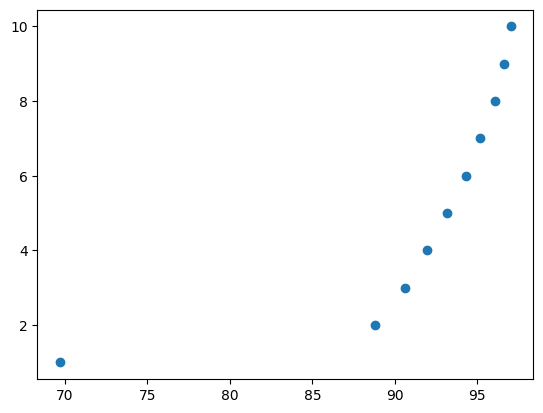

In [81]:
import matplotlib.pyplot as plt

accuracies = [69.708, 88.78, 90.593, 91.955, 93.189, 94.316, 95.185, 96.054, 96.599, 97.024]
epochs = np.arange(10)+1
plt.scatter(accuracies, epochs)
plt.plot()

[]

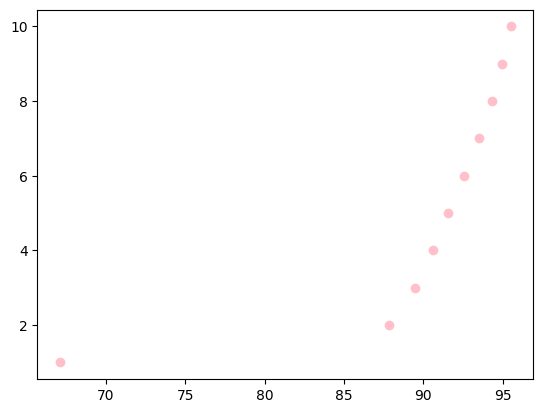

In [82]:
accuracies = [67.105, 87.864, 89.483, 90.59700000000001, 91.582, 92.54599999999999, 93.506, 94.337, 94.931, 95.50699999999999]
epochs = np.arange(10)+1
plt.scatter(accuracies, epochs, color = 'pink')
plt.plot()